Use Nasdaq as the universe and alpha 101 as the factors

In [125]:
from pathlib import Path
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import polars as pl
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr
import seaborn as sns
from talib import WMA

In [7]:
data_dir = Path("../../../data")
stock_dir = data_dir / "nasdaq100"
qqq_path = data_dir / "QQQ.csv"

## Read Nasdaq 100 stocks and QQQ as benchmark

In [8]:
def parse_date(datetime_str: str) -> datetime:
    dt, tz = datetime_str.rsplit(" ", maxsplit=1)

    date_time_obj = datetime.strptime(dt, "%Y%m%d %H:%M:%S").replace(
        tzinfo=ZoneInfo(tz)
    )
    return date_time_obj


def read_stock(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(
        file_path,
        names=[
            "date",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "vmap",
            "ticks",
        ],
    )
    df["date"] = df["date"].map(parse_date)
    df.set_index("date", inplace=True)
    return df


def plot_stock(df: pd.DataFrame, ticker: str) -> None:
    """Plot stock price with plotly and show earning rate in title."""
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=df.index, y=df["close"], mode="lines", name="close")
    )

    er = (df["close"].iloc[-1] - df["close"].iloc[0]) / df["close"].iloc[0]
    fig.update_layout(title=f"{ticker} | Earning Rate: {er:.2%}")
    fig.show()


def sharpe_ratio(df: pd.DataFrame, risk_free: float = None) -> float:
    """Calculate sharpes ratio."""
    pc = df["close"].pct_change()
    if risk_free:
        return (pc.mean() - risk_free) / pc.std()
    else:
        return pc.mean() / pc.std()

In [9]:
df_qqq = read_stock(qqq_path)

In [10]:
stocks = {}

for stock in tqdm(stock_dir.glob("*.csv")):
    ticker = stock.stem
    df = read_stock(stock)
    stocks[ticker] = df

    # print(f"{ticker} Sharpe Ratio: {sharpe_ratio(df, risk_free=0.04):.2f}")
    # print(f"{ticker} CAGR: {((df['close'].iloc[-1] / df['close'].iloc[0]) ** (1/len(df)) - 1):.2%}")
    # print(f"{ticker} Max Drawdown: {((df['close'].max() - df['close'].min()) / df['close'].max()):.2%}")
    # print(f"{ticker} Beta: {df['close'].corr(df_qqq['close']):.2f}")
    # print(f"{ticker} Alpha: {((df['close'].pct_change() - 0.01).mean() - (df_qqq['close'].pct_change() - 0.01).mean()):.2%}")

98it [00:10,  9.57it/s]


In [11]:
df = pd.concat(stocks.values(), keys=stocks.keys(), axis=1)

In [12]:
(len(df) - len(df.dropna(how="any"))) / len(df)

0.3905961893054702

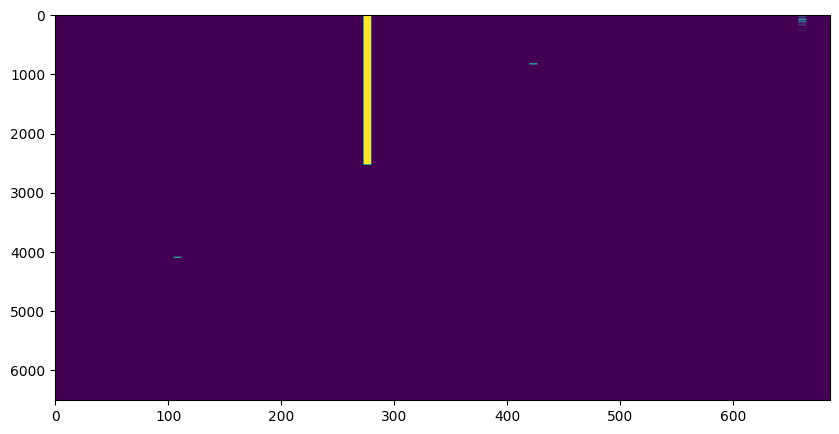

In [13]:
# visualize nan values
plt.figure(figsize=(10, 5))
plt.imshow(df.isnull(), aspect="auto")

In [14]:
for ticker in df.columns.levels[0]:
    # count nan ratio
    nan_ratio = df[ticker].isnull().sum() / len(df)
    if nan_ratio.max() > 0.2:
        # get first non-nan date
        first_date = df[ticker][df[ticker].notna().all(axis=1)].index[0]
        print(f"{ticker} has nan ratio: {nan_ratio.max():.2%}, first date: {first_date}")

GEHC has nan ratio: 38.86%, first date: 2022-12-15 09:30:00-05:00


In [17]:
for ticker in ["GEHC"]:
    ticker = yf.Ticker(ticker)
    # get IPO date
    print(datetime.fromtimestamp(ticker.info["firstTradeDateEpochUtc"]).strftime("%Y-%m-%d"))

2022-12-15


The data missing is caused by API, drop them

In [60]:
# drop GEHC in level 0
df = df.drop(columns=["GEHC"], level=0)
df = df.dropna(how="any")

In [19]:
df = df.swaplevel(axis=1).sort_index(axis=1)

In [77]:
tickers = df.close.columns.tolist()

In [79]:
# add returns df to df
df_returns = df.close.pct_change()
df_returns.columns = pd.MultiIndex.from_product([["returns"], tickers])
df = pd.concat([df, df_returns], axis=1)

## Functions

In [117]:
def log(df):
    return np.log1p(df)


def power(df, exp):
    return df.pow(exp)


def ts_max(df, window=10):
    return df.rolling(window).max()


def ts_std(df, window=10):
    return df.rolling(window).std()


def rank(df):
    return df.rank(axis=1, pct=True)


def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax).add(1)


def ts_delta(df, period=1):
    return df.diff(period)


def ts_corr(x, y, window=10):
    return x.rolling(window).corr(y)

## Alphas

### Alpha 001

In [ ]:
def alpha001(c, r):
    c[r < 0] = ts_std(r, 20)
    return rank(ts_argmax(power(c, 2), 5)).sub(0.5).stack().swaplevel()

In [ ]:
a1 = alpha001(df.close, df.returns)

c:\Users\ntj_0\Anaconda3\envs\qr\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


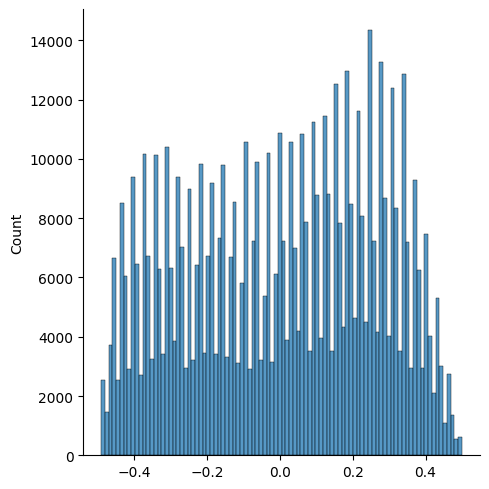

In [116]:
sns.displot(a1)

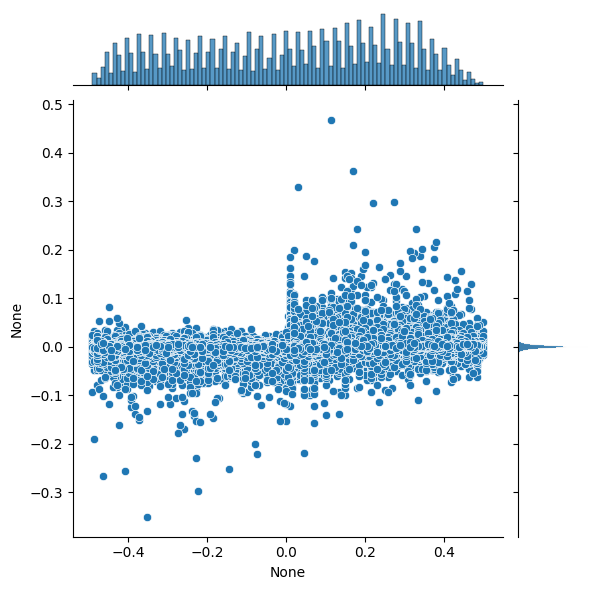

In [114]:
sns.jointplot(x=a1, y=df.returns.stack().swaplevel())

### Alpha 002

In [126]:
def alpha002(o, c, v):
    """(-1 * ts_corr(rank(ts_delta(log(volume), 2)), rank(((close - open) / open)), 6))"""
    s1 = rank(ts_delta(log(v), 2))
    s2 = rank((c / o) - 1)
    alpha = -ts_corr(s1, s2, 6)
    return alpha.replace([-np.inf, np.inf], np.nan).stack().swaplevel()

In [119]:
a2 = alpha002(df.open, df.close, df.volume)

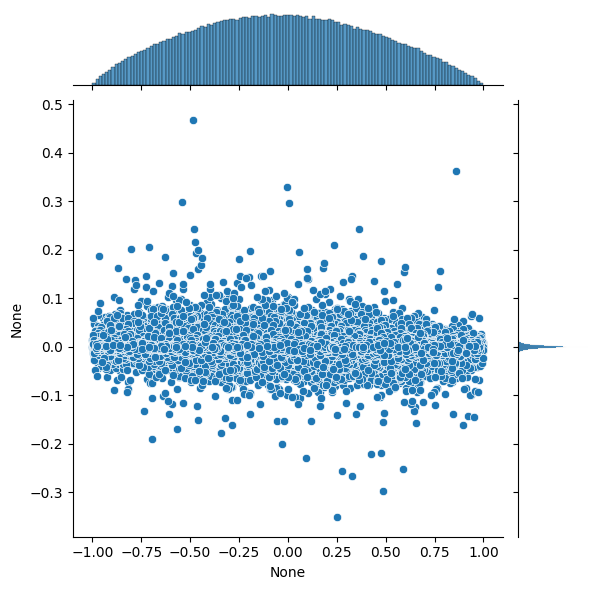

In [120]:
sns.jointplot(x=a2, y=df.returns.stack().swaplevel())

### Alpha 003

In [127]:
def alpha003(o, v):
    """(-1 * ts_corr(rank(open), rank(volume), 10))"""

    return (
        -ts_corr(rank(o), rank(v), 10)
        .replace([-np.inf, np.inf], np.nan)
        .stack()
        .swaplevel()
    )

In [128]:
a3 = alpha003(df.open, df.volume)

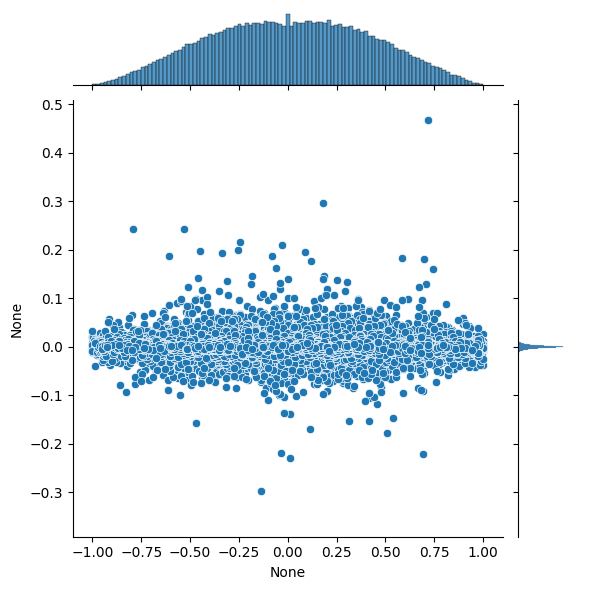

In [129]:
sns.jointplot(x=a3, y=df.returns.shift(-1).stack().swaplevel())